In [1]:
!pip3 install git+https://github.com/am1tyadav/tfutils.git

  Cloning https://github.com/am1tyadav/tfutils.git to /tmp/pip-req-build-mwklv4x8
  Running command git clone -q https://github.com/am1tyadav/tfutils.git /tmp/pip-req-build-mwklv4x8
  Created wheel for tfutils: filename=tfutils-0.0.1-cp36-none-any.whl size=6442 sha256=b39bb3e7a23ed83a7a5188112db9b8fde6ac1a962801006bd1489d9127d46649
  Stored in directory: /tmp/pip-ephem-wheel-cache-xis1rh0e/wheels/fc/ae/41/9164f4ea031c0d70c13ba0d3fa9ab01c6783b36d6324db18ec
Successfully built tfutils


In [2]:
#Libraries
import os
import keras
import tfutils
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization


Dataset loading...
11493376/11490434 [==============================] - 0s 0us/step
Dataset loaded successfully!



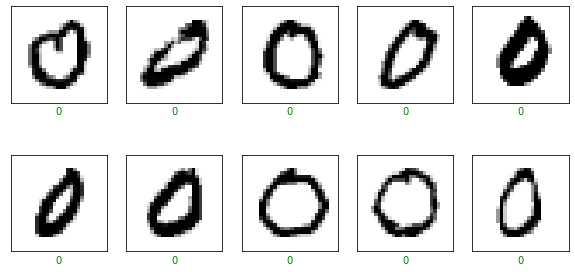

In [3]:

#Image Loading and PreProcessing
print("")
print('Dataset loading...')
(xtrain, ytrain), (xtest, ytest) = tfutils.datasets.mnist.load_data(one_hot = False)
print('Dataset loaded successfully!')
print("")
xtrain = tfutils.datasets.mnist.load_subset([0], xtrain, ytrain)
xtest = tfutils.datasets.mnist.load_subset([0], xtest, ytest)
x = np.concatenate([xtrain, xtest], axis = 0)
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1))).show()

In [4]:
discriminator = Sequential(
    [
        Conv2D(64, 3, strides=2, input_shape = (28,28,1)), LeakyReLU(), BatchNormalization(),
        Conv2D(128, 5, strides=2), LeakyReLU(), BatchNormalization(),
        Conv2D(256, 3, strides=2), LeakyReLU(), BatchNormalization(),
        Flatten(),
        Dense(1, activation = 'sigmoid')
    ]
)
Optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1 = 0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=Optimizer, metrics=['accuracy'])
print('Discriminator Summary')
discriminator.summary()

Discriminator Summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None

In [5]:
generator = Sequential(
    [
        Dense(256, activation='relu', input_shape=(1,)), Reshape((1,1,256)),
        Conv2DTranspose(256, 5, activation='relu'), BatchNormalization(),
        Conv2DTranspose(128, 5, activation='relu'), BatchNormalization(),
        Conv2DTranspose(64, 5, strides=2, activation='relu'), BatchNormalization(),
        Conv2DTranspose(32, 5, activation='relu'), BatchNormalization(),
        Conv2DTranspose(1, 4, activation='sigmoid')
    ]
)
print('Generator Summary')
generator.summary()

Generator Summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 

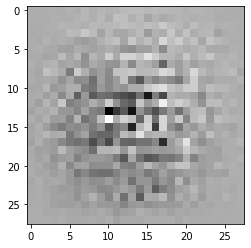

In [6]:
# To check if the generator is working
noise = np.random.randn(1,1)
generated_image = generator.predict(noise)[0]
plt.figure()
"""
To reshape the generated image as pyplot doesn't accept channels dimention
as it is a black and white image.
"""
plt.imshow(np.reshape(generated_image,(28,28)), cmap='binary')
plt.show()

In [7]:
#noise input
input_layer = tf.keras.layers.Input(shape=(1,))
generator_out = generator(input_layer)
discriminator_out = discriminator(generator_out)
gan = Model(input_layer, discriminator_out)
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=Optimizer, metrics=['accuracy'])

print('GAN SUMMARY')
gan.summary()

GAN SUMMARY
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 503553    
Total params: 3,220,578
Trainable params: 2,716,065
Non-trainable params: 504,513
_________________________________________________________________


In [8]:
epoch = 25
batch_size = 128
steps_per_epoch = int(2*x.shape[0]/batch_size)
print('Steps per Epoch = ', steps_per_epoch)

Steps per Epoch =  107


In [14]:
dynamic_plotting = tfutils.plotting.DynamicPlot(plt,5,5,(8,8))

<Figure size 576x576 with 0 Axes>

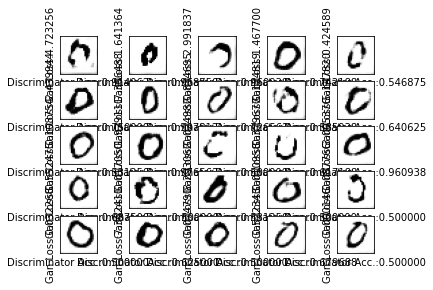

In [17]:
for e in range(0, epoch):
    dynamic_plotting.start_of_epoch(e)
    for step in range(0, steps_per_epoch):
        true_example = x[int(batch_size/2)*step:int(batch_size/2)*(step+1)]
        true_example = np.reshape(true_example,(true_example.shape[0],28,28,1))
        noise = np.random.randn(int(batch_size/2),1)
        generator_example = generator.predict(noise)

        #batches
        xbatch = np.concatenate([generator_example,true_example],axis=0)
        ybatch = np.array([0]*int(batch_size/2)+[1]*int(batch_size/2))

        #randomize the order
        indices = np.random.choice(range(batch_size), batch_size, replace = False)

        xbatch = xbatch[indices]
        ybatch = ybatch[indices]

        discriminator.trainable=True
        discriminator.train_on_batch(xbatch, ybatch)
        discriminator.trainable=False

        loss, _ = gan.train_on_batch(noise, np.ones(int(batch_size/2)))
        _, acc = discriminator.evaluate(xbatch, ybatch, verbose=False)

    noise = np.random.randn(1,1)
    generated_image = generator.predict(noise)[0]
    generated_image = np.reshape(generated_image,(28,28))
    dynamic_plotting.end_of_epoch(generated_image,'binary','Discriminator Acc.:{:2f}'.format(acc),'Gan Loss:{:2f}'.format(loss))